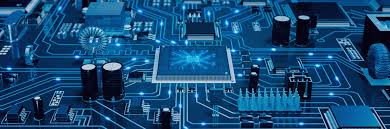

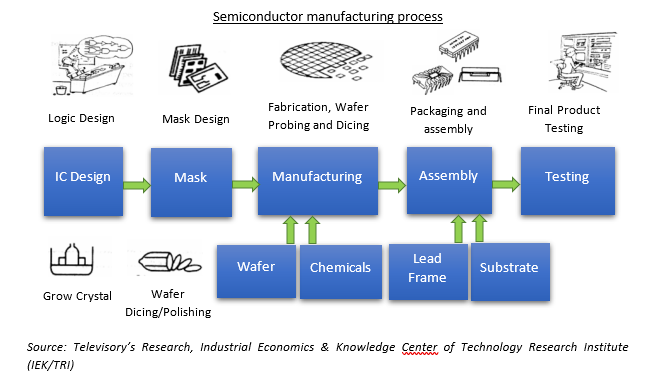


# Product entity yield type prediction

## Domain
### Semiconductor manufacturing process
## Business Context
#### A complex modern semiconductor manufacturing process is normally under constant
#### surveillance via the monitoring of signals/variables collected from sensors and or
#### process measurement points. However, not all of these signals are equally valuable in
#### a specific monitoring system.
#### The measured signals contain a combination of useful information, irrelevant
#### information as well as noise. Engineers typically have a much larger number of signals
#### than are actually required. If we consider each type of signal as a feature, then feature
#### selection may be applied to identify the most relevant signals. The Process Engineers
#### may then use these signals to determine key factors contributing to yield excursions
#### downstream in the process. This will enable an increase in process throughput,
#### decreased time to learning and reduce the per unit production costs.
#### These signals can be used as features to predict the yield type. And by analyzing and
#### trying out different combinations of features, essential signals that are impacting the
#### yield type can be identified.

## Objective
#### We will build a classifier to predict the Pass/Fail yield of a particular process entity and
#### analyze whether all the features are required to build the model or not.

## Dataset description 

#### sensor-data.csv : (1567, 592)
#### The data consists of 1567 examples each with 591 features.
#### The dataset presented in this case represents a selection of such features where each
#### example represents a single production entity with associated measured
#### features and the labels represent a simple pass/fail yield for in house line
#### testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and
#### the data time stamp is for that specific test point.

## Steps
1. Import the necessary liberraries and read the provided CSV as a dataframe and
perform the below steps. 
a. Check a few observations and shape of the dataframe
b. Check for missing values. Impute the missing values if there is any
c. Univariate analysis - check frequency count of target column and
distribution of the first few features (sensors)
d. Perform bivariate analysis and check for the correlation
e. Drop irrelevant columns
2. Standardize the data 
3. Segregate the dependent column ("Pass/Fail") from the data frame. And split
the dataset into training and testing set ( 70:30 split) 
4. Build a logistic regression, random forest, and xgboost classifier model and print
confusion matrix for the test data 
5. Apply sampling techniques to handle the imbalanced classes 
6. Build a logistic regression, random forest, and xgboost classifier model after resampling the data and print the confusion matrix for the test data 
7. Apply Grid Search CV to get the best hyper parameters for any one of the above
model 
8. Build a classifier model using the above best hyper parameters and check the
accuracy and confusion matrix 
9. Report feature importance and mention your comments 

10. Report your findings and inferences 
Further Questions ( Optional) -
1. Check for outliers and impute them as required.
2. Apply PCA to get rid of redundant features and reduce dimension of the data
3. Try cross validation techniques to get better results
4. Try OneCLassSVM model to get better recall

### Learning Outcomes
* Feature Importance
* Sampling
* SMOTE
* Grid Search
* Random Forest
* Exploratory Data Analysis
* Logistic Regression

## Import Some Basic Libraries

In [ ]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for modeling 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# for providing path
import os
print(os.listdir("../input"))


## Reading the Data and understanding the attributes

In [ ]:
# reading the data
data = pd.read_csv('../input/uci-secom.csv')

# getting the shape of the data
# we have 1,567 rows and 592 columns
print(data.shape)


In [ ]:
# getting the head of the data

data.head()

In [ ]:
# checking if the dataset contains any NULL values
# we do have NaN values if we see the output above

data.isnull().any().any()

In [ ]:
# Replacing all the NaN values with 0 as the values correspond to the test results.
# since, the values are not present that means the values are not available or calculated
# Absence of a signal is assumed to be no signal in the dataset
# so better we not take median or mean and replace them with zeros

data = data.replace(np.NaN, 0)

# again, checking if there is any NULL values left
data.isnull().any().any()

## Data Visualization

In [ ]:
unique_vals = data['Pass/Fail'].unique()  # [0, 1, 2]
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]

In [ ]:
fig = plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize = 20)

#sns.add_legend()
#plt.legend()
fig.legend(labels=['Pass','Fail'])
plt.show()


In [ ]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass

labels = ['Pass', 'Fail']
size = data['Pass/Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind="bar");

In [ ]:
# heatmap to get correlation

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 20)

## Data Cleaning/Preprocessing

In [ ]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [ ]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
data = remove_collinear_features(data,0.70)

In [ ]:
# deleting the first column

data = data.drop(columns = ['Time'], axis = 1)

# checking the shape of the data after deleting a column
data.shape

In [ ]:
data.head()

In [ ]:
# separating the dependent and independent data

x = data.iloc[:,:306]
y = data["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

In [ ]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

In [ ]:
# standardization

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


## XGBoost Algorithm (Normal data)

In [ ]:
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

#### In the failure class we have only 1 observation classified correctly for XGBoost but still has 94.5% accuracy as we predicted correctly on the observations that passed

## Random Forest Classifier (Normal Data)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

#### In the failure class we have no observation classified correctly for Random Forest but still has 94.5% accuracy as we predicted correctly on the observations that passed

## Logistic Regression (Normal Data)

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

#### In the failure class we have 4 observation classified correctly for logistic regression and 88% accuracy as we predicted correctly on the observations that passed. So even though this model has lesser accuracy it is preferable over previous models as at least it is classifying more observations in the failure class correctly

## Lasso (Normal Data)

In [ ]:

lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train,y_train)
#print ("Lasso model:", (lasso.coef_))

y_pred = lasso.predict(x_test)

#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

In [ ]:
print("Accuracy: ", lasso.score(x_test,y_test)*100)

In [ ]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## UnderSampling of the Dataset

In [ ]:
# Under Sampling - Check how many failure observations are there
# We have 104 such observations

failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

In [ ]:
# Check how many pass observations are there
# We have 1,463 such observations

normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

In [ ]:
# Get 104 random observations from the pass class as well

random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

In [ ]:
#Getting a 50-50 representation from both pass and fail classes
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

In [ ]:
# creating the undersample data

undersample_data = data.iloc[under_sample, :]

In [ ]:

# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

In [ ]:
# standardization

sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

## Xg-Boost Classifier (Undersampling)

In [ ]:


model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

## Confusion Matrix after UnderSampling with XgBoost

In [ ]:


cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

# It is able to predict 26 defected semiconductors among 35 Semi-Conductors

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

## Grid Search - XG Boost (Undersampling)

In [ ]:
# Applying Grid Search CV to find the best model with the best parameters



parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [ ]:
print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

In [ ]:


weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

## Confusion matrix XG Boost - Grid Search (Undersample)

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

**Most Important Features of the Model**

In [ ]:
# plotting the feature importances

colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (100, 100)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

## Over-Sampling with SMOTE

In [ ]:


x_resample, y_resample  = SMOTE(random_state=1).fit_sample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

In [ ]:


x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

In [ ]:
# standardization



sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

## Xg-Boost Classifier - Grid Search (Oversampling)

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=1)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

In [ ]:
# Applying Grid Search CV to find the best model with the best parameters

from sklearn.model_selection import GridSearchCV

# making a parameters list
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_



In [ ]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

In [ ]:


weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)


## Confusion Matrix after OverSampling with XgBoost

In [ ]:


cm = confusion_matrix(y_test_os, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

## Random Forest (Oversampling)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_os, y_train_os)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_os)
print("Accuracy: ", model.score(x_test_os,y_test_os)*100)

## Random Forest - (Oversampled) - Confusion Matrix

In [ ]:
# printing the confusion matrix
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Logistic regression - (Oversampled)

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_os, y_train_os) 
y_pred = lr.predict(x_test_os)

print("Accuracy: ", lr.score(x_test_os,y_test_os)*100)

## Logistic regression (Oversampled) - Confusion matrix

In [ ]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Random Forest - (Undersampled)

In [ ]:

model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_us)

## Confusion Matrix for Random Forest (Undersampled)

In [ ]:
# evaluating the model

# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

## Using Lasso (Undersampled)

In [ ]:

lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)
#print ("Lasso model:", (lasso.coef_))

In [ ]:
y_pred = lasso.predict(x_test_us)

In [ ]:
print(y_pred)

In [ ]:
print(y_test_us)

In [ ]:
#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

## Confusion matrix for Lasso (Undersampled)

In [ ]:
cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [ ]:
print("Accuracy: ", lasso.score(x_test_us,y_test_us)*100)

## Logistic Regression (Undersampled)

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us) 

In [ ]:
y_pred = lr.predict(x_test_us)

## Confusion matrix for Logistic Regression (Undersampled)

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [ ]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

> **Local Outlier Factor Classifier,** Succesfully detected 11 defected items out of 13, that makes an impeccable accuracy of 85% Recall Accuracy. This algorithm would have been worked even better if the data was a little bigger with more instances of defected items.

## One Class SVM (Undersampled)

> In one-class SVM, the support vector model is trained on data that has only one class, which is the “normal” class. It infers the properties of normal cases and from these properties can predict which examples are unlike the normal examples. This is useful for anomaly detection because the scarcity of training examples is what defines anomalies: that is, typically there are very few examples of the network intrusion, fraud, or other anomalous behavior.

In [ ]:


model = OneClassSVM(kernel ='rbf', degree=3, gamma=0.1,nu=0.005, max_iter=-1, random_state=1)

model.fit(x_train_us, y_train_us)
y_pred = model.fit_predict(x_test_us)


## Confusion Matrix for One Class SVM

In [ ]:

# evaluating the model
# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm ,annot = True, cmap = 'winter')


In [ ]:
#print("Accuracy: ", model.score(x_test,y_test)*100)

## OneClassSVM - (Oversampled) 

In [ ]:
model = OneClassSVM(kernel ='rbf', degree=3, gamma=0.1,nu=0.005, max_iter=-1, random_state=1)

model.fit(x_train_os, y_train_os)
y_pred = model.fit_predict(x_test_os)

## Confusion matrix for OneClassSVM - (Oversampled)

In [ ]:
# evaluating the model
# printing the confusion matrix
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm ,annot = True, cmap = 'winter')

## Using PCA for demensionality reduction

In [ ]:
#Scaling the data before applying PCA
from scipy.stats import zscore
data_new=data.iloc[:,:306].apply(zscore)
data_new.head()

In [ ]:
data_new.isnull().any().any()

In [ ]:
data_new = data_new.replace(np.NaN, 0)

In [ ]:
data_new.isnull().any().any()

In [ ]:
# separating the dependent and independent data

x = data_new.iloc[:,:306]
y = data["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

In [ ]:
# PCA
# Step 1 - Create covariance matrix

cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

In [ ]:
# Step 2- Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

In [ ]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

In [ ]:
plt.plot(var_exp)

In [ ]:
# Ploting 
plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
len(cum_var_exp)

In [ ]:
# Using scikit learn PCA here. It does all the above steps and maps data to PCA dimensions in one shot
from sklearn.decomposition import PCA

# NOTE - we are generating only 130 PCA dimensions (dimensionality reduction from 306 to 130)
# For 130 components we are getting approximately 90% of the variance
pca = PCA(n_components=130)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

In [ ]:
pca.components_

In [ ]:
df_comp = pd.DataFrame(pca.components_,columns=list(x))
df_comp.head()

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [ ]:
data_reduced.shape

In [ ]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()

In [ ]:
df_red3 = df_red2.copy()
df_red4 = df_red3
df_red4["Pass/Fail"] = data["Pass/Fail"]

In [ ]:
df_red4.head()

In [ ]:
df_red4.shape

In [ ]:
#Causing system crash and taking too much time, so commented out
#sns.pairplot(df_red4,diag_kind='kde')

In [ ]:
#Sample boxplot shows that there are outliers in the data, let us fix them
df_red4.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ]
                          , by = 'Pass/Fail', figsize=(20,20))

In [ ]:
#Create a copy of the dataset for maintain data after outlier removal
#Here after identifying outliers we replace with median
pd_data = df_red4.copy()
#pd_data.head()

#pd_data2 = pd_data.drop(columns=['name'],axis=1)
#pd_data2 = pd_data2.apply(replace,axis=1)
from scipy import stats

#Define a function to remove outliers on max side
def outlier_removal_max(var):
    var = np.where(var > var.quantile(0.75)+ stats.iqr(var),var.quantile(0.50),var)
    return var

#Define a function to remove outliers on min side
def outlier_removal_min(var):
    var = np.where(var < var.quantile(0.25) - stats.iqr(var),var.quantile(0.50),var)
    return var

#Loop over the columns and remove the outliers on min and max side
for column in pd_data:
    pd_data[column] = outlier_removal_max(pd_data[column])
    pd_data[column] = outlier_removal_min(pd_data[column])

In [ ]:
#Sample boxplot shows that outliers are fixed, but we are loosing observations belonging to failure 
#class (Pass/Fail = 1) So we should not remove outliers here 
pd_data.boxplot( column =[df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ],by = 'Pass/Fail', figsize=(20,20))

In [ ]:
# separating the dependent and independent data

x = df_red4.iloc[:, df_red4.columns != 'Pass/Fail'] 
y = df_red4.iloc[:, df_red4.columns == 'Pass/Fail']

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

In [ ]:
# Under Sampling - Check how many failure observations are there
# We have 104 such observations

failed_tests = np.array(df_red4[df_red4['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

In [ ]:
# Check how many pass observations are there
# We have 1,463 such observations

normal_indices = df_red4[df_red4['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

In [ ]:
# Get 104 random observations from the pass class as well

random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

In [ ]:
#Getting a 50-50 representation from both pass and fail classes
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

In [ ]:
# creating the undersample data

undersample_data = df_red4.iloc[under_sample, :]

# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

In [ ]:
# standardization - completed before PCA itself

#sc = StandardScaler()
#x_train_us = sc.fit_transform(x_train_us)
#x_test_us = sc.transform(x_test_us)


## XGBoost - PCA (undersampled)

In [ ]:
model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)

## Confusion matrix for XG Boost - PCA - (Undersampled)

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})



In [ ]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

## XG Boost - PCA - Grid Search - Undersampled

In [ ]:
# Applying Grid Search CV to find the best model with the best parameters



parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
             'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

In [ ]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

print("Accuracy: ", model.score(x_test_us,y_test_us)*100)


## Confusion matrix of XG Boost - Grid Search - PCA - Undersampled

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})


## Random Forest - PCA - Undersampled

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_us)

# evaluating the model

# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')



In [ ]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

## Logistic Regression - PCA - Undersampled

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us) 
y_pred = lr.predict(x_test_us)
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')


In [ ]:
print("Accuracy: ", lr.score(x_test_us,y_test_us)*100)

## Lasso - PCA - Undersampled

In [ ]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)
#print ("Lasso model:", (lasso.coef_))

y_pred = lasso.predict(x_test_us)

#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

In [ ]:
actual_cost = list(y_test_us)
actual_cost = np.asarray(actual_cost)
y_pred_lass = lasso.predict(x_test_us)

In [ ]:
print("Accuracy: ", lasso.score(x_test_us, y_test_us)*100)

## Confusion Matrix for Lasso - PCA - Undersampled

In [ ]:

cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Elliptic Envelop technique

In [ ]:
# defining outlier fraction for Elliptic Envelop, Isolation Forest and Local Outlier Factor

Fraud = data[data['Pass/Fail']==1]
Valid = data[data['Pass/Fail']==-1]

outlier_fraction = len(Fraud)/float(len(Valid))
print("Outlier Fraction :", outlier_fraction)

In [ ]:
from sklearn.covariance import EllipticEnvelope
model = EllipticEnvelope(contamination=outlier_fraction, random_state=1)
model.fit(x_train, y_train)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test)

In [ ]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Isolation Forest technique

In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, max_samples=len(x_train), 
                                       contamination=outlier_fraction, random_state=1, verbose=0)
model.fit(x_train, y_train)
scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test)

In [ ]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Local Outlier Factor Technique

In [ ]:
from sklearn.neighbors import LocalOutlierFactor


model = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, 
                           metric_params=None, contamination=outlier_fraction)

model.fit(x_train, y_train)
y_pred = model.fit_predict(x_test)

In [ ]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Comparison of All Algorithms' Recall Rate

In [ ]:
Recall = np.array([84.4, 87.9, 81.3,9.4,0,0,0])
label = np.array(['Isolation Forest', 'Local Outlier Factor', 'Elliptic Envelop',
                  'Logistic','XGBoost','Random Forest','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Normal Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
Recall = np.array([74.3,77.1,71.4,77.1,71.4,17.1])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso','OneClass SVM'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Undersampled Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
Recall = np.array([74.3,77.1,71.4,77.1,71.4,17.1])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso','OneClass SVM'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Oversampled Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
Recall = np.array([54.5,63.6,48.5,69.7,51.5])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - PCA Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# plotting the feature importances

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
pyplot.rcParams.update({'font.size': 22})
from matplotlib.pyplot import figure
figure(num=None, figsize=(100, 100), dpi=80, facecolor='w', edgecolor='k')
# fit model no training data
model = XGBClassifier()
model.fit(x_train_us, y_train_us)
# plot feature importance
plot_importance(model)
pyplot.show()

In [ ]:
featureImp = []
for feat, importance in zip(data.columns, model.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False))

## We have tried multiple models Logistic Regression, Random Forest, XG Boost (with and without Grid Search),OneClassSVM, Elliptic Envelop, Isolation Forest and Local Outlier Factor for the imbalanced classes
## Across methods OneClassSVM performed the worst while Local Outlier Factor performed the best in terms of recall accuracy
## We saw that for imbalanced classes accuracy and recall are invertially proportional to each other. Better recall models have lower accuracy and vice versa.
## We have tried two sampling techniques -first one using SMOTE (oversampling) and second one 
## using random based method (undersampling), Oversampling gave better results than undersampling in 
## terms of accuracy. Recall score was similar for both undersampling and oversampling.
## We did Z score scaling on both the datasets and took PCA with n_components as 130 (90% variance coverage). However PCA did not improve either accuracy or recall probably as we were loosing information due to dropping dimensions.
## We tried K-fold cross validation within XG Boost itself with bext value as 2 for all the models
## Using feature importance, we found that 72, 74 and 45 are the top three important 
## features. The best recall value at 88% was for Local Outlier Factor algorithm, the best part was no sampling was required as the algorithm took care of sampling as well as outliers. 
## classifier on the failure observations